In [94]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.features import build_features
from src.visualization import visualize

sns.set_theme(palette="pastel")
plt.rcParams["figure.figsize"] = (12, 6)

# Asumiendo que es una ocupacion del 80% de camas
INDICE_OCUPACION_CAMAS = 1.25

# Agrega las columnas de poblacion de interes
COLUMNAS_POBLACION_INTERES = [i for i in range(2017, 2036)]

# Proyección de casos INT al 2035

En este cuadernillo se quiere estimar la deminada que atenderá el INT para el 2035. Con esta demanada se calcularán las cantidades de camas necesarias para suplir tal demanda. Para determinar la demanda se utilizarán:

1. Cantidad de casos teóricos por problemas de salud relevantes seleccionados: Estos se calcularon según la incidencia de cada problema de salud y la proyección de la población al 2035.

2. Cantidad de casos atendidos actualmente por cada problema de salud: Estos se obtuvieron al analizar la base de egresos hospitalarios DEIS.

Con ambos datos, se obtendrá cuanto % de atención ha cubierto el INT de los casos teóricos.

In [168]:
# Obtiene los casos de area de influencia
casos_area_de_influencia = pd.read_excel(
    "../data/interim/casos_teoricos_diagnosticos.xlsx", sheet_name="casos_area_de_influencia_INT"
)

# Preprocesa el diagnostico
casos_area_de_influencia["Diagnostico"] = (
    casos_area_de_influencia["Diagnostico"].str.split(" - ").str[0]
)

# Preprocesa los diagnosticos agrupados
casos_area_de_influencia["Diagnosticos Contenidos"] = casos_area_de_influencia[
    "Diagnosticos Contenidos"
].str.split(", ")

In [169]:
# Obtiene los diagnosticos relevantes a filtrar de los egresos hospitalarios
DIAGNOSTICOS_RELEVANTES = list(
    casos_area_de_influencia["Diagnostico"].str.split(" - ").str[0].unique()
)

# Obtiene los diagnosticos agrupados
DIAGNOSTICOS_AGRUPADOS = list(
    casos_area_de_influencia.explode("Diagnosticos Contenidos")["Diagnosticos Contenidos"]
    .dropna()
    .str.strip()
    .unique()
)

# Suma los diagnosticos agrupados a los diagnosticos relevantes
DIAGNOSTICOS_RELEVANTES += DIAGNOSTICOS_AGRUPADOS
DIAGNOSTICOS_RELEVANTES = sorted(DIAGNOSTICOS_RELEVANTES)

In [170]:
# Genera duplas de diagnosticos a reasignar
DIAGNOSTICOS_A_REASIGNAR = casos_area_de_influencia.query("`Diagnosticos Contenidos`.notna()")[
    ["Diagnostico", "Diagnosticos Contenidos"]
]

In [171]:
for row in DIAGNOSTICOS_A_REASIGNAR.itertuples():
    diagnostico_nuevo = row[1]
    diagnosticos_antiguos = row[2]
    print(f"Los diagnosticos {diagnosticos_antiguos} seran reasignados a {diagnostico_nuevo}")

Los diagnosticos ['C341', 'C342', 'C343', 'C780', 'C782', 'D381'] seran reasignados a C34N


## Obtencion de casos teoricos para cada diagnóstico relevante segun incidencia

Estos seran obtenidos desde el cuadernillo 1.0-jrb-number-of-persons-per-strata

In [172]:
# Importa los casos teoricos por cada problema de salud
casos_teoricos_nacionales = pd.read_excel(
    "../data/interim/casos_teoricos_diagnosticos.xlsx", sheet_name="casos_teoricos_INE"
)
casos_teoricos_nacionales["Diagnostico"] = (
    casos_teoricos_nacionales["Diagnostico"].str.split("-").str[0].str.strip()
)

# Extrae los diagnosticos relevantes para el recinto hospitalario
casos_teoricos_nacionales = casos_teoricos_nacionales.set_index("Diagnostico")

# Renombra columnas
COLUMNAS_A_RENOMBRAR = {
    "2017": 2017,
    "2018": 2018,
    "2019": 2019,
    "2020": 2020,
    "2021": 2021,
    "2022": 2022,
    "2023": 2023,
    "2024": 2024,
    "2025": 2025,
    "2026": 2026,
    "2027": 2027,
    "2028": 2028,
    "2029": 2029,
    "2030": 2030,
    "2031": 2031,
    "2032": 2032,
    "2033": 2033,
    "2034": 2034,
    "2035": 2035,
}
casos_teoricos_nacionales = casos_teoricos_nacionales.rename(columns=COLUMNAS_A_RENOMBRAR)

# Obtiene los casos en el estrato nacional
casos_pais = casos_teoricos_nacionales.query("Estrato == 'Pais'").copy().sort_index()
casos_pais_del_2017_al_2020 = casos_pais[[i for i in range(2017, 2020)]]

In [174]:
print(
    f"Los diagnosticos que seran proyectados son: \n{DIAGNOSTICOS_RELEVANTES} "
    f"\ny son {len(DIAGNOSTICOS_RELEVANTES)}"
)

Los diagnosticos que seran proyectados son: 
['A152', 'B441', 'C341', 'C342', 'C343', 'C34N', 'C381', 'C780', 'C782', 'D381', 'E848', 'I051', 'I052', 'I080', 'I081', 'I232', 'I330', 'I340', 'I351', 'I352', 'I35C', 'I35D', 'I35X', 'I361', 'I420', 'I421', 'I495', 'I710', 'I711', 'I712', 'I715', 'J679', 'J841', 'J848', 'J955', 'M051', 'M348', 'Q222', 'Q233', 'Q257', 'Z450'] 
y son 41


## Obtención de casos atendidos entre 2017 y 2020 para diagnósticos relevantes.

Estos se obtendrán del análisis de egresos hospitalarios a nivel país DEIS.

In [175]:
# Carga los egresos nacionales
egresos_nacionales = pd.read_csv(
    "../data/raw/4_resumen_egresos_nacionales/ranking_nacional_egresos.csv",
    sep=";",
    encoding="latin-1",
)

# Filtra solamente los datos del INT
egresos_torax = egresos_nacionales.query("ESTABLECIMIENTO_SALUD == 112103").copy()

En primer lugar, se filtrarán ambas bases de datos para solamente tener la información de los diagnósticos más relevantes para el INT. Luego de esto, se calculará la cantidad de egresos, dias de estada y pacientes para cada uno de los diagnósticos. Estos insumos serán utilizados para estimar la demanda.


In [176]:
# Filtra solamente los diagnosticos mas relevantes del Torax
egresos_mas_relevantes_nacionales = (
    egresos_nacionales[egresos_nacionales["DIAG1"].isin(DIAGNOSTICOS_RELEVANTES)]
    .query("ANO_EGRESO >= 2017 and ANO_EGRESO <= 2019")
    .copy()
)

Previo a calcular las métricas para cada diagnóstico, es necesario agrupar algunos de ellos. Esto se debe a que ciertas incidencias fueron imposible de encontrar, como por ejemplo con:

- **I052 - Estenosis mitral con insuficiencia**: El 100% de los egresos y cantidad de pacientes será asignado al diagnóstico I051 - Insuficiencia mitral reumática. Sólamente se calculará la cantidad de casos teóricos para la insuficiencia mitral reumática.

- **I080 - Trastornos de las válvulas mitral y aórtica**: El 100% de los egresos y cantidad de pacientes será asignado al diagnóstico I340 - Insuficiencia (de la válvula) mitral y I350 - Estenosis (de la válvula) aórtica.

- **I081 - Trastornos de las válvulas mitral y tricúspide**: El 100% de los egresos y cantidad de pacientes será asignado al diagnóstico I340 - Insuficiencia (de la válvula) mitral y I361 - Insuficiencia no reumática (de la válvula) tricúspide.

In [177]:
# Reasigna I052
egresos_mas_relevantes_nacionales["DIAG1"] = (
    egresos_mas_relevantes_nacionales["DIAG1"].replace({"I052": "I051"}).copy()
)

# Reasigna I080 a I340 y I350 (Estenosis Mitral y Aortica, respectivamente)
egresos_mas_relevantes_nacionales = build_features.assign_diagnosis(
    egresos_mas_relevantes_nacionales, "I080", "I340", "I350"
)

# Reasigna I081 a I340 y I361 (Estenosis Mitral, y Valvulopatia Tricuspide)
egresos_mas_relevantes_nacionales = build_features.assign_diagnosis(
    egresos_mas_relevantes_nacionales, "I081", "I340", "I361"
)

Además, también se reasignarán los diagnósticos de:

- C341 - Tumor maligno del lóbulo superior, bronquio o pulmón
- C342 - Tumor maligno del lóbulo medio, bronquio o pulmón
- C343 - Tumor maligno del lóbulo inferior, bronquio o pulmón
- C780 - Tumor maligno secundario del pulmón
- C782 - Tumor maligno secundario de la pleura
- D381 - Tumor de comportamiento incierto o desconocido de la tráquea, de los bronquios y del pulmón

Todos estos se reasignarán al diagnóstico C34XN (N, para que no se mezclen con los C34X asignados realmente así). Esto, con el fin de poder calcular las estadísticas agrupadas para todos estos diagnósticos (egresos por persona, días de estada).

In [178]:
# Reasigna C341, C342, C343, C780, C782, D381 a C34XN
egresos_mas_relevantes_nacionales["DIAG1"] = (
    egresos_mas_relevantes_nacionales["DIAG1"].replace(
        ["C341", "C342", "C343", "C780", "C782", "D381"], "C341"
    )
).copy()

In [179]:
# Filtra solamente los diagnosticos relevantes para el torax
egresos_mas_relevantes_torax = egresos_mas_relevantes_nacionales.query(
    "ESTABLECIMIENTO_SALUD == 112103"
).copy()

In [180]:
# Obtiene el resumen de metricas para el estrato nacional
metricas_diags_relevantes_nacionales = build_features.calculate_discharges_metrics(
    egresos_mas_relevantes_nacionales
)

# Obtiene resumen de metricas para el Torax
metricas_diags_relevantes_torax = build_features.calculate_discharges_metrics(
    egresos_mas_relevantes_torax
)

Solamente se compararán los casos reales vs teóricos entre 2017 y 2020, ya que la información se encuentra disponible en tales periodos.

En primer lugar, se obtendrá el porcentaje de atención del INT del total de casos teóricos. O sea:

$$\%atencion = \frac{Casos Reales}{Casos Teoricos}$$

La cantidad de casos están desglosados por año, por lo que es posible calcular un porcentaje de atención anual. Sin embargo, para efectos de cálculo, se obtendrá el porcentaje acumulado entre los años disponibles (2017 a 2020).

$$\%Atencion\ Acumulada = \frac{\sum_{2017}^{2020}Casos Reales}{\sum_{2017}^{2020}Casos Teoricos}$$

In [181]:
round(casos_pais_del_2017_al_2020).astype(int)

,2017,2018,2019
Diagnostico,,,
A152,2450,2494,2541
C34N,7368,7501,7643
C381,221,225,229
E848,26,25,26
I051,1405,1431,1458
I232,155,158,161
I330,460,469,478
I340,1405,1431,1458
I351,92096,93757,95536


In [182]:
# Obtiene cuanto se hace cargo el INT de los pacientes teoricos
porcentaje_hosp_teorica_nacionales = (
    metricas_diags_relevantes_nacionales["n_pacientes_distintos"]
    .sum(axis=1)
    .div(casos_pais_del_2017_al_2020.sum(axis=1), axis=0)
)

In [183]:
display(porcentaje_hosp_teorica_nacionales.to_frame().head(10).style.format("{:,.2%}"))

,0
A152,0.69%
B441,nan%
C341,nan%
C34N,nan%
C381,17.77%
E848,159.29%
I051,4.19%
I232,1.26%
I330,81.67%
I340,37.31%


Una vez se sabe la proporcion de los casos que atiende el INT históricamente, se procederá a estimar cuántos casos atenderá si es que se mantiene en las mismas condiciones actuales (mismo porcentaje de atención del nacional, mismos egresos por personas y mismos dias de estada por persona).

Ademas, se leerán los casos asignados al INT según área de influencia.

## Estimación utilizando el % de Hospitalización Nacional

In [184]:
# Lee casos de area de influencia INT
casos_INT = pd.read_excel(
    "../data/interim/casos_teoricos_diagnosticos.xlsx", sheet_name="casos_area_de_influencia_INT"
)


DIAGNOSTICOS_A_ELIMINAR = ["C342", "C343", "C780", "C782", "D381", "I052", "I080", "I081"]
# Pone Diagnosticos como indice
casos_INT["Diagnostico"] = casos_INT["Diagnostico"].str.split(" - ").str[0]
# Elimina diagnosticos con incidencia y prevalencia
casos_INT = casos_INT.drop_duplicates("Diagnostico")

# Elimina diagnosticos agrupados
casos_INT = casos_INT.query("~Diagnostico.isin(@DIAGNOSTICOS_A_ELIMINAR)")
casos_INT = casos_INT.set_index("Diagnostico")

# Renombra columnas a tipo numero
casos_INT = casos_INT.rename(columns=COLUMNAS_A_RENOMBRAR)

In [185]:
# Se obtiene la cantidad de casos que debiese atender el Torax, asumiendo que atendera
# lo mismo que entre 2017 y 2020 del total de casos teoricos
casos_INT_hospitalizados = casos_INT[COLUMNAS_POBLACION_INTERES].mul(
    porcentaje_hosp_teorica_nacionales, axis=0
)

# Se obtiene la cantidad de egresos que debiese tener el INT, asumiendo que trabajara con la misma
# eficiencia
egresos_estimados_INT = casos_INT_hospitalizados.mul(
    metricas_diags_relevantes_torax["egresos_por_paciente_agrupado"]["2017-2020"], axis=0
)

# Se obtiene la cantidad de dias de estada que debiese el INT, asumiendo que trabajara con la misma
# eficiencia
dias_estada_estimados_int = egresos_estimados_INT.mul(
    metricas_diags_relevantes_torax["dias_estada_promedio_agrupado"]["2017-2020"], axis=0
)

# Estima la cantidad de camas necesaarias por diagnostico
camas_estimadas_int = (dias_estada_estimados_int / 365.25) * INDICE_OCUPACION_CAMAS

# Ademas, obtiene la cantidad de camas utilizadas realmente por el INT
camas_reales_ocupadas_int = (
    metricas_diags_relevantes_torax["dias_estada_totales"].sum() / 365.25
) * INDICE_OCUPACION_CAMAS

In [186]:
comparacion_camas = pd.concat([camas_estimadas_int.sum(), camas_reales_ocupadas_int], axis=1)
comparacion_camas.columns = ["Estimadas", "Reales"]

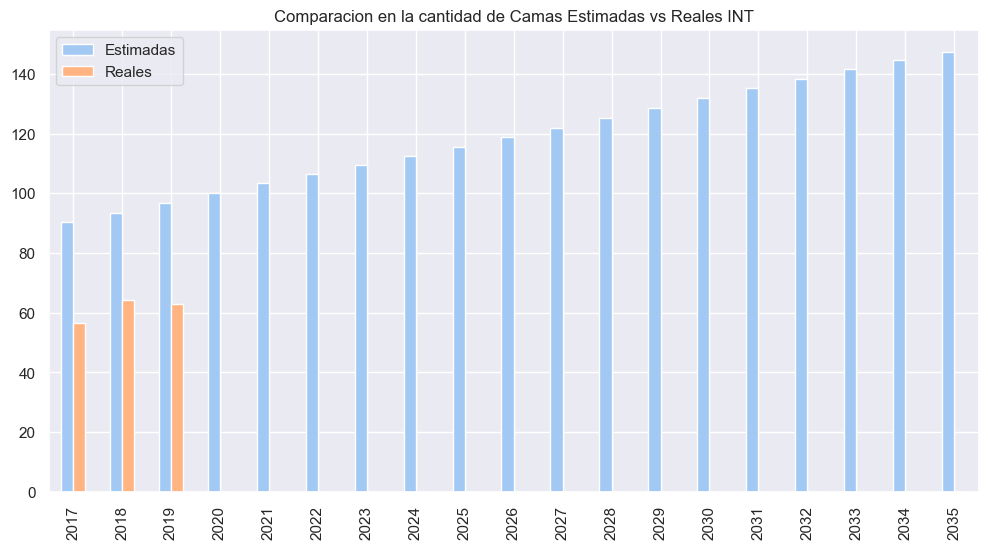

In [187]:
comparacion_camas.plot(kind="bar")
plt.title("Comparacion en la cantidad de Camas Estimadas vs Reales INT")
plt.show()

En este caso, se muestra la cantidad de camas que necesitaría el INT para atender los problemas de salud relevantes. Cabe destacar que esta es la cantidad de camas siguiendo solamente el crecimiento natural de la población, sin ningún cierre de brecha.

Sin embargo, es importante notar la labor sanitaria del INT, y su compromiso con el cierre de brechas. Por lo tanto, es necesario saber en que problemas de salud existe una brecha de atención a nivel nacional.

In [188]:
porcentaje_atencion_teorica_nacional = (
    metricas_diags_relevantes_nacionales["n_pacientes_distintos"]
    .sum(axis=1)
    .div(casos_pais_del_2017_al_2020.sum(axis=1), axis=0)
) * 100

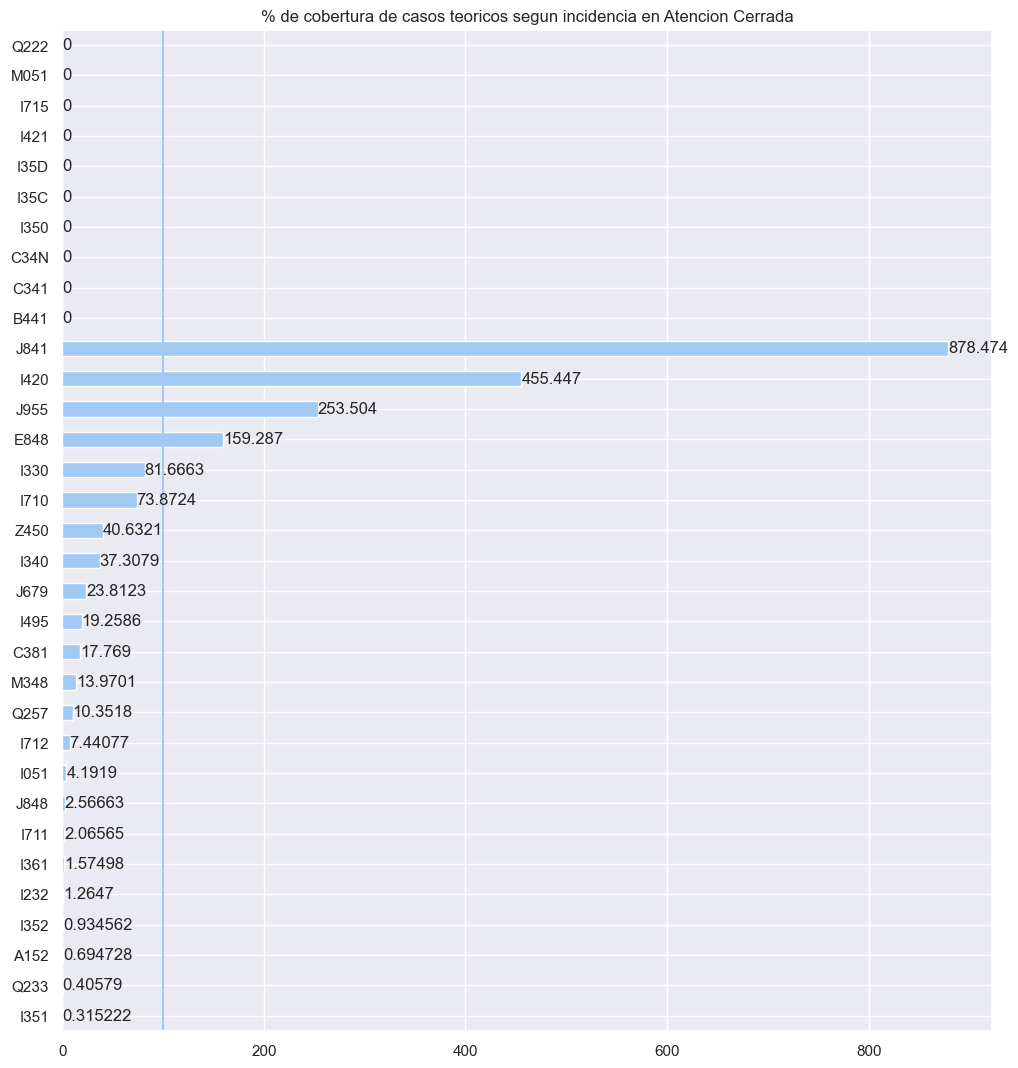

In [189]:
fig, axis = plt.subplots(figsize=(12, 13))
porcentaje_atencion_teorica_nacional.sort_values().plot(kind="barh", ax=axis)
for i in axis.containers:
    axis.bar_label(i)

plt.axvline(100)
plt.title("% de cobertura de casos teoricos segun incidencia en Atencion Cerrada")
plt.show()

## Estimación de casos Hospitalizados utilizando % de Hospitalización del INT

En este caso, se utilizará el % de hospitalización del INT de los pacientes ambulatorios.

In [190]:
PORCENTAJE_HOSPITALIZADOS = pd.read_excel(
    "../data/external/incidencias_y_prevalencias_INT.xlsx",
    usecols=["Diagnostico", "Porcentaje Hospitalizados de Ambulatorios"],
)

PORCENTAJE_HOSPITALIZADOS = PORCENTAJE_HOSPITALIZADOS.drop_duplicates("Diagnostico")

PORCENTAJE_HOSPITALIZADOS["Diagnostico"] = (
    PORCENTAJE_HOSPITALIZADOS["Diagnostico"].str.split(" - ").str[0]
)
PORCENTAJE_HOSPITALIZADOS = PORCENTAJE_HOSPITALIZADOS.set_index("Diagnostico")[
    "Porcentaje Hospitalizados de Ambulatorios"
]

In [191]:
casos_INT_hospitalizados_porcentaje_amb = casos_INT[COLUMNAS_POBLACION_INTERES].mul(
    PORCENTAJE_HOSPITALIZADOS, axis=0
)

# Se obtiene la cantidad de egresos que debiese tener el INT, asumiendo que trabajara con la misma
# eficiencia
egresos_estimados_INT_porcentaje_amb = casos_INT_hospitalizados_porcentaje_amb.mul(
    metricas_diags_relevantes_torax["egresos_por_paciente_agrupado"]["2017-2020"], axis=0
)

# Se obtiene la cantidad de dias de estada que debiese el INT, asumiendo que trabajara con la misma
# eficiencia
dias_estada_estimados_int_porcentaje_amb = egresos_estimados_INT_porcentaje_amb.mul(
    metricas_diags_relevantes_torax["dias_estada_promedio_agrupado"]["2017-2020"], axis=0
)

# Estima la cantidad de camas necesaarias por diagnostico
camas_estimadas_int_porcentaje_amb = (
    dias_estada_estimados_int_porcentaje_amb / 365.25
) * INDICE_OCUPACION_CAMAS

# Calcula las camas totales necesarias
camas_totales_int_porcentaje_amb = camas_estimadas_int_porcentaje_amb.sum()

In [192]:
print(camas_totales_int_porcentaje_amb)

2017    440.962094
2018    449.379363
2019    458.480694
2020    467.690010
2021    473.875189
2022    478.579451
2023    482.920855
2024    487.151921
2025    491.310059
2026    495.386112
2027    499.367048
2028    503.237383
2029    506.981873
2030    510.584331
2031    514.154023
2032    517.643825
2033    521.087190
2034    524.477780
2035    527.818569
dtype: float64


## Guardar archivos

In [193]:
archivos_a_guardar = {
    "metricas_relevantes_INT": metricas_diags_relevantes_torax,
    "casos_hospitalizados_INT": casos_INT_hospitalizados_porcentaje_amb,
    "egresos_estimados_INT": egresos_estimados_INT_porcentaje_amb,
    "dias_estada_estimados_INT": dias_estada_estimados_int_porcentaje_amb,
    "camas_estimadas_desglosadas_INT": camas_estimadas_int_porcentaje_amb,
    "camas_totales_INT": camas_totales_int_porcentaje_amb,
}

with pd.ExcelWriter("../data/interim/estimacion_atencion_cerrada_INT.xlsx") as file:
    for nombre_hoja, df_a_guardar in archivos_a_guardar.items():
        print(f"Guardando {nombre_hoja}")
        df_a_guardar.to_excel(file, sheet_name=nombre_hoja)

Guardando metricas_relevantes_INT
Guardando casos_hospitalizados_INT
Guardando egresos_estimados_INT
Guardando dias_estada_estimados_INT
Guardando camas_estimadas_desglosadas_INT
Guardando camas_totales_INT
